# VPRM timeseries

This tutorial will show you how to create timeseries of emission for the vegetation 
photosynthesis and respiration model (VPRM) within emiproc.

We will first prepare the input data, then run the model and finally visualize the results.

If you want to learn more how to use emiproc VPRM, you can check [the documentation](https://emiproc.readthedocs.io/en/master/emissions_generation.html#vprm) 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import urllib.request

from pathlib import Path
from emiproc import  FILES_DIR
from emiproc.profiles.vprm import calculate_vegetation_indices, calculate_vprm_emissions

plt.style.use('default')

# Set up the working directory, change this if you want to check the files
# in a different location
work_dir = FILES_DIR / 'vprm'
work_dir.mkdir(exist_ok=True, parents=True)

## Prepare input data

To run VPRM we need the following input data:

- Satellite data to calculate the vegetation indices (EVI: Enhanced Vegetation Index and 
  NDVI: Normalized Difference Vegetation Index)
- Meteorological data (temperature and radiation)
- Vegetation parameters (constants for different vegetation types used in the model)


This tutorial will focus on the city of Zurich, which provide good open source data.

We will run vprm for the year 2024, with an hourly resolution.
We won't treat spatial resolution in this tutorial, so we are only interested in the temporal profiles.

### Meteorological data

The city of zurich provides a good [meteorological dataset](https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte), wo we can use this directly.

In [2]:

downlaod_link_meteo = "https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte/download/ugz_ogd_meteo_h1_2024.csv"
# Download the meteorological data
meteo_file = work_dir / 'meteo.csv'

if not meteo_file.is_file():
    urllib.request.urlretrieve(downlaod_link_meteo, meteo_file)

df_meteo = pd.read_csv(meteo_file, parse_dates=['Datum'])
df_meteo.head(10)

,Datum,Standort,Parameter,Intervall,Einheit,Wert,Status
0,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,T,h1,°C,5.23,bereinigt
1,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,Hr,h1,%Hr,77.04,bereinigt
2,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,p,h1,hPa,961.72,bereinigt
3,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,RainDur,h1,min,0.00,bereinigt
4,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,StrGlo,h1,W/m2,0.02,bereinigt
5,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,WD,h1,°,240.37,bereinigt
6,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,WVv,h1,m/s,2.76,bereinigt
7,2024-01-01 00:00:00+01:00,Zch_Stampfenbachstrasse,WVs,h1,m/s,2.89,bereinigt
8,2024-01-01 00:00:00+01:00,Zch_Schimmelstrasse,T,h1,°C,5.09,bereinigt
9,2024-01-01 00:00:00+01:00,Zch_Schimmelstrasse,Hr,h1,%Hr,91.81,bereinigt


For VPRM we need to extract the Temperature and radiation.
So we will try to get the `T` and the `StrGlo` parameters from the data.

In [3]:
cols = {}
for var_in_data, var in {
    "T": "T",
    "StrGlo": "Rad",
}.items():

    mask_var = df_meteo["Parameter"] == var_in_data
    # Make the average over the different stations
    serie = df_meteo.loc[mask_var, ["Datum", "Wert"]].groupby("Datum").mean()['Wert']
    cols[var] = serie

df_meteo_cleaned = pd.concat(cols, axis=1)
# Put to utc 
df_meteo_cleaned.index = df_meteo_cleaned.index.tz_convert('UTC').tz_localize(None)
df_meteo_cleaned

,T,Rad
Datum,,
2023-12-31 23:00:00,4.6075,0.02
2024-01-01 00:00:00,4.5350,0.01
2024-01-01 01:00:00,4.7275,0.01
2024-01-01 02:00:00,4.6750,0.02
2024-01-01 03:00:00,4.5000,0.02
...,...,...
2024-12-31 18:00:00,-0.6100,0.02
2024-12-31 19:00:00,-0.9900,0.02
2024-12-31 20:00:00,-1.0375,0.02


We can have a look at the data

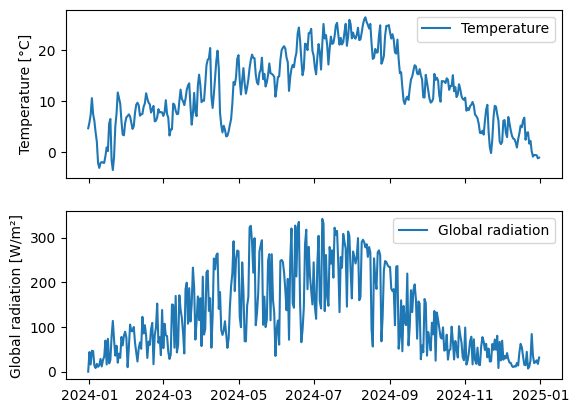

In [4]:
fig, axes = plt.subplots(2, 1,sharex=True)
df_daily = df_meteo_cleaned.resample("d").mean()
axes[0].plot(df_daily.index, df_daily["T"], label="Temperature")
axes[0].set_ylabel("Temperature [°C]")
axes[0].legend()
axes[1].plot(df_daily.index, df_daily["Rad"], label="Global radiation")
axes[1].set_ylabel("Global radiation [W/m²]")
axes[1].legend()


As expected, the temperature and radiation have daily fluctuations as well as seasonal ones. 

It seems we can use that data for the next steps.

### Satellite indicies 

We will use the `EVI` and `LSWI` indices to calculate the vegetation parameters.

Usually you would need to download some satellite data and calculate the indices yourself.
Then you will get the indices for different moment in the year.

This is a bit tedious, so here we will simply use some timeseries that are already generated. In case you want to do it yourself, you can follow [this python tutorial](https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NDVI_Timeseries.html)


The satellite indices are not always given directly, if you need to calculate them, you can
use the emiproc function 
[calculate_vegetation_indices](https://emiproc.readthedocs.io/en/master/api/models.html#emiproc.profiles.vprm.calculate_vegetation_indices)

In [5]:
df_sat = pd.read_csv(work_dir / "vegetation_indices.csv", index_col=0, header=[0, 1], 
                 parse_dates=True)
df_sat

Cropland        Deciduous        Evergreen        Grassland       
                evi   lswi       evi   lswi       evi   lswi       evi   lswi
2021-01-24      NaN    NaN       NaN    NaN     0.318  0.686       NaN    NaN
2021-02-20    0.478  0.261       NaN    NaN     0.380  0.334     0.484  0.223
2021-02-23    0.444  0.265       NaN    NaN     0.292  0.380     0.499  0.256
2021-02-25    0.469  0.238     0.279  0.034     0.302  0.389     0.555  0.274
2021-03-02    0.494  0.240     0.235 -0.046     0.318  0.413     0.567  0.253
...             ...    ...       ...    ...       ...    ...       ...    ...
2025-04-15      NaN    NaN       NaN    NaN       NaN    NaN     0.971  0.450
2025-04-23    0.568  0.428     0.585  0.378     0.389  0.448     0.823  0.464
2025-04-27      NaN    NaN     0.407  0.396       NaN    NaN     0.887  0.424
2025-04-28    0.670  0.438     0.584  0.403     0.353  0.382     0.752  0.460
2025-04-30    0.652  0.443     0.746  0.425     0.440  0.411     0.827  0.461

[302 rows x 8 columns]

This table contains the evi and ndvi indices for different vegetation types
at different days in time (where a satellite pass was available).

<Axes: >

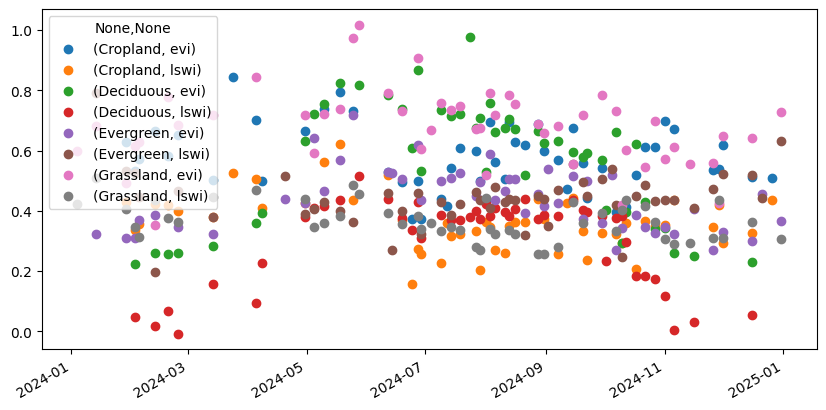

In [6]:
df_sat.loc["2024"].plot(linestyle="", marker='o', figsize=(10, 5))

We need to interpolate the data to get estimates for the whole year.
Since it is very stochastic, we use a robust method to interpolate the data.

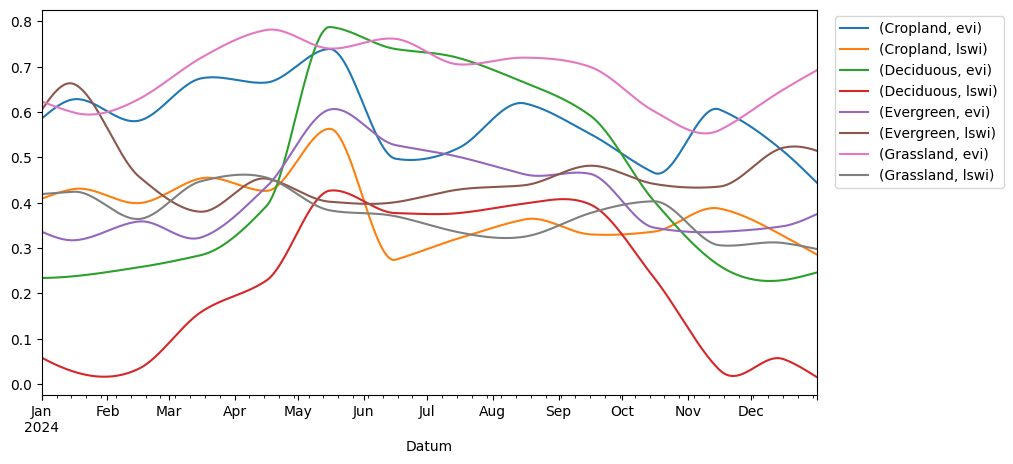

In [7]:
# monthly median
df_sat_monthly_mean = df_sat.resample("MS").median()
# Add 15 days to be at the middle of the month
df_sat_monthly_mean.index = df_sat_monthly_mean.index + pd.Timedelta(days=15)
# Resample to hourly data and interpolate for the missing values
df_sat_full = df_sat_monthly_mean.resample("h").interpolate(method="akima").reindex(
    df_meteo_cleaned.index
)

ax = df_sat_full.plot(figsize=(10, 5))
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

This is a very rough estimate, but most of the important features are captured.

We see lower values in the winter and higher values in the summer.
Cropland has a huge drop in summer, which can happen when the crops are harvested.

### Vegetation parameters

For the parameters, we will use the original parameters from the [VPRM paper](https://doi.org/10.1029/2006GB002735).

In [8]:
df_indices_mahadevan = pd.read_csv(work_dir / "vprm_parameters.csv", index_col="Site")
df_indices_mahadevan


,Tmin,Topt,Tmax,Tlow,PAR0,lambda,alpha,beta,std-PAR0,std-lambda,std-alpha,std-beta
Site,,,,,,,,,,,,
HARVARD,0,20,40,5.0,570,0.127,0.271,0.25,14,0.002,0.006,0.060
HOWLAND,0,20,40,2.0,629,0.123,0.244,-0.24,17,0.002,0.004,0.036
NOBS,0,20,40,1.0,262,0.234,0.244,0.14,5,0.004,0.002,0.015
NIWOT,0,20,40,1.0,446,0.128,0.250,0.17,13,0.003,0.003,0.018
METOLIUS,0,20,40,2.0,1206,0.097,0.295,-0.43,39,0.002,0.003,0.028
SOY_MEADS2,5,22,40,2.0,2051,0.064,0.209,0.20,137,0.002,0.005,0.058
CORN_MEAD,5,22,40,2.0,11250,0.075,0.173,0.82,1746,0.002,0.006,0.081
TONZI,2,20,40,0.0,3241,0.057,0.012,0.58,293,0.002,0.002,0.036
VAIRA,2,18,40,0.0,542,0.213,0.028,0.72,23,0.006,0.002,0.035


## Run VPRM
Now that we have all the input data, we can run VPRM.

This is simply done by calling the function [calculate_vprm_emissions](https://emiproc.readthedocs.io/en/master/api/models.html#emiproc.profiles.vprm.calculate_vprm_emissions) .
If you look at the documentation, you can also see the equations used.

In [9]:
# Put all the timeseries together
df_vprm = df_sat_full.copy()
df_vprm[('T', 'global')] = df_meteo_cleaned['T']
df_vprm[('RAD', 'global')] = df_meteo_cleaned['Rad']
df_vprm



Cropland           Deciduous           Evergreen  \
                          evi      lswi       evi      lswi       evi   
Datum                                                                   
2023-12-31 23:00:00  0.585600  0.408814  0.233792  0.057975  0.335923   
2024-01-01 00:00:00  0.585762  0.408886  0.233794  0.057870  0.335838   
2024-01-01 01:00:00  0.585925  0.408958  0.233795  0.057766  0.335754   
2024-01-01 02:00:00  0.586088  0.409029  0.233797  0.057661  0.335669   
2024-01-01 03:00:00  0.586251  0.409101  0.233798  0.057557  0.335585   
...                       ...       ...       ...       ...       ...   
2024-12-31 18:00:00  0.445183  0.286038  0.245662  0.015723  0.374151   
2024-12-31 19:00:00  0.444992  0.285928  0.245715  0.015602  0.374239   
2024-12-31 20:00:00  0.444801  0.285817  0.245768  0.015482  0.374327   
2024-12-31 21:00:00  0.444610  0.285707  0.245822  0.015362  0.374415   
2024-12-31 22:00:00  0.444418  0.285597  0.245875  0.015241  0.374503   

                              Grassland                 T    RAD  
                         lswi       evi      lswi  global global  
Datum                                                             
2023-12-31 23:00:00  0.604519  0.623039  0.418926  4.6075   0.02  
2024-01-01 00:00:00  0.604807  0.622966  0.418943  4.5350   0.01  
2024-01-01 01:00:00  0.605095  0.622893  0.418960  4.7275   0.01  
2024-01-01 02:00:00  0.605382  0.622820  0.418977  4.6750   0.02  
2024-01-01 03:00:00  0.605669  0.622747  0.418994  4.5000   0.02  
...                       ...       ...       ...     ...    ...  
2024-12-31 18:00:00  0.514763  0.691655  0.297948 -0.6100   0.02  
2024-12-31 19:00:00  0.514695  0.691764  0.297909 -0.9900   0.02  
2024-12-31 20:00:00  0.514627  0.691873  0.297869 -1.0375   0.02  
2024-12-31 21:00:00  0.514559  0.691982  0.297829 -1.1550   0.02  
2024-12-31 22:00:00  0.514490  0.692091  0.297790 -0.9725   0.02  

[8784 rows x 10 columns]

In [10]:
# Choose which site to use for each category (rename the index)
# Of course this is not what you should do 
# in a real application you should optimize the model to find the best parameters
# but since we are just doing a tutorial, we will use the default parameters
df_indices = df_indices_mahadevan.rename(
    index={
        "NOBS": "Evergreen",
        "HARVARD": "Deciduous",
        "CORN_MEAD": "Cropland",
        "VAIRA": "Grassland",
        
    }
)
df_indices

,Tmin,Topt,Tmax,Tlow,PAR0,lambda,alpha,beta,std-PAR0,std-lambda,std-alpha,std-beta
Site,,,,,,,,,,,,
Deciduous,0,20,40,5.0,570,0.127,0.271,0.25,14,0.002,0.006,0.060
HOWLAND,0,20,40,2.0,629,0.123,0.244,-0.24,17,0.002,0.004,0.036
Evergreen,0,20,40,1.0,262,0.234,0.244,0.14,5,0.004,0.002,0.015
NIWOT,0,20,40,1.0,446,0.128,0.250,0.17,13,0.003,0.003,0.018
METOLIUS,0,20,40,2.0,1206,0.097,0.295,-0.43,39,0.002,0.003,0.028
SOY_MEADS2,5,22,40,2.0,2051,0.064,0.209,0.20,137,0.002,0.005,0.058
Cropland,5,22,40,2.0,11250,0.075,0.173,0.82,1746,0.002,0.006,0.081
TONZI,2,20,40,0.0,3241,0.057,0.012,0.58,293,0.002,0.002,0.036
Grassland,2,18,40,0.0,542,0.213,0.028,0.72,23,0.006,0.002,0.035


In [11]:
df_emissions = calculate_vprm_emissions(
    df=df_vprm,
    df_vprm=df_indices,
    
)

Missing HOWLAND in the observation dataframe, skipping
Missing NIWOT in the observation dataframe, skipping
Missing METOLIUS in the observation dataframe, skipping
Missing SOY_MEADS2 in the observation dataframe, skipping
Missing TONZI in the observation dataframe, skipping
Missing DONALDSON in the observation dataframe, skipping
Missing LUCKY-HILLS in the observation dataframe, skipping
Missing PEATLAND in the observation dataframe, skipping


## Plot VPRM results

Now we have another function that helps us to visualize the results.

### Average daily cycle for each month

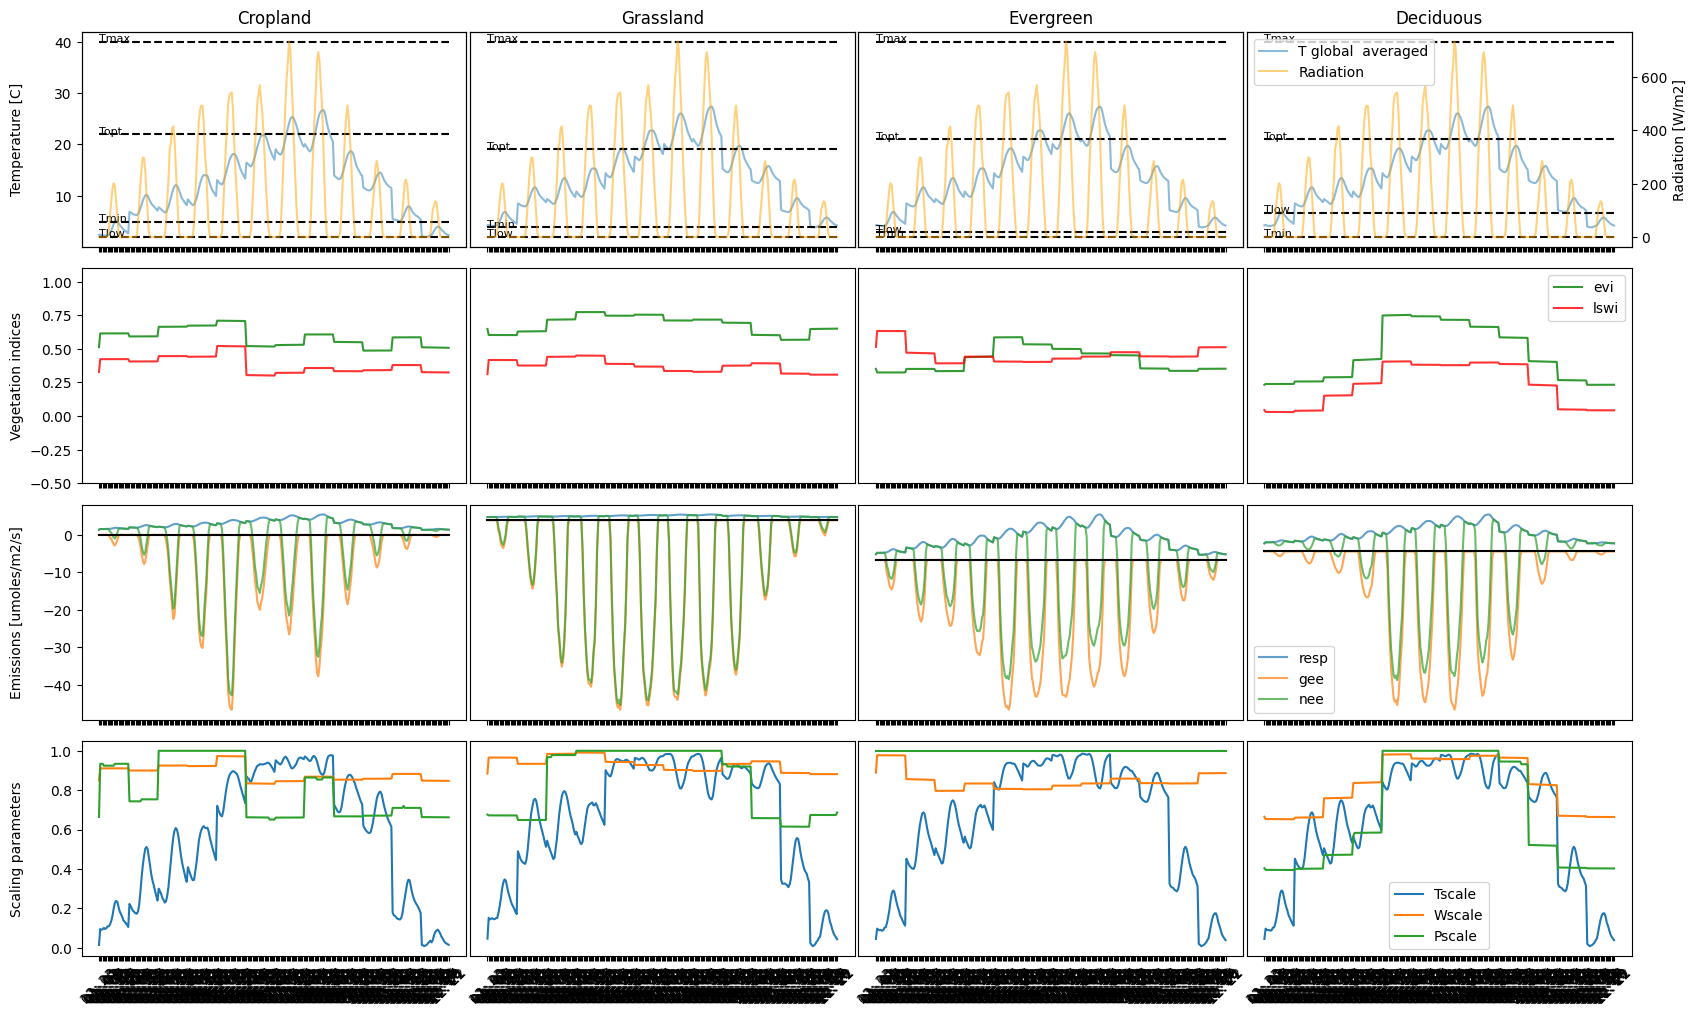

In [12]:
from emiproc.plots.vprm import plot_vprm_params_per_veg_type


plot_vprm_params_per_veg_type(df_emissions, df_indices, group_by='%m: %H')

We see nice diurnal cycles, which are stronger in summer.

Different other parameters are shown to help us understand the results.

### Daily means

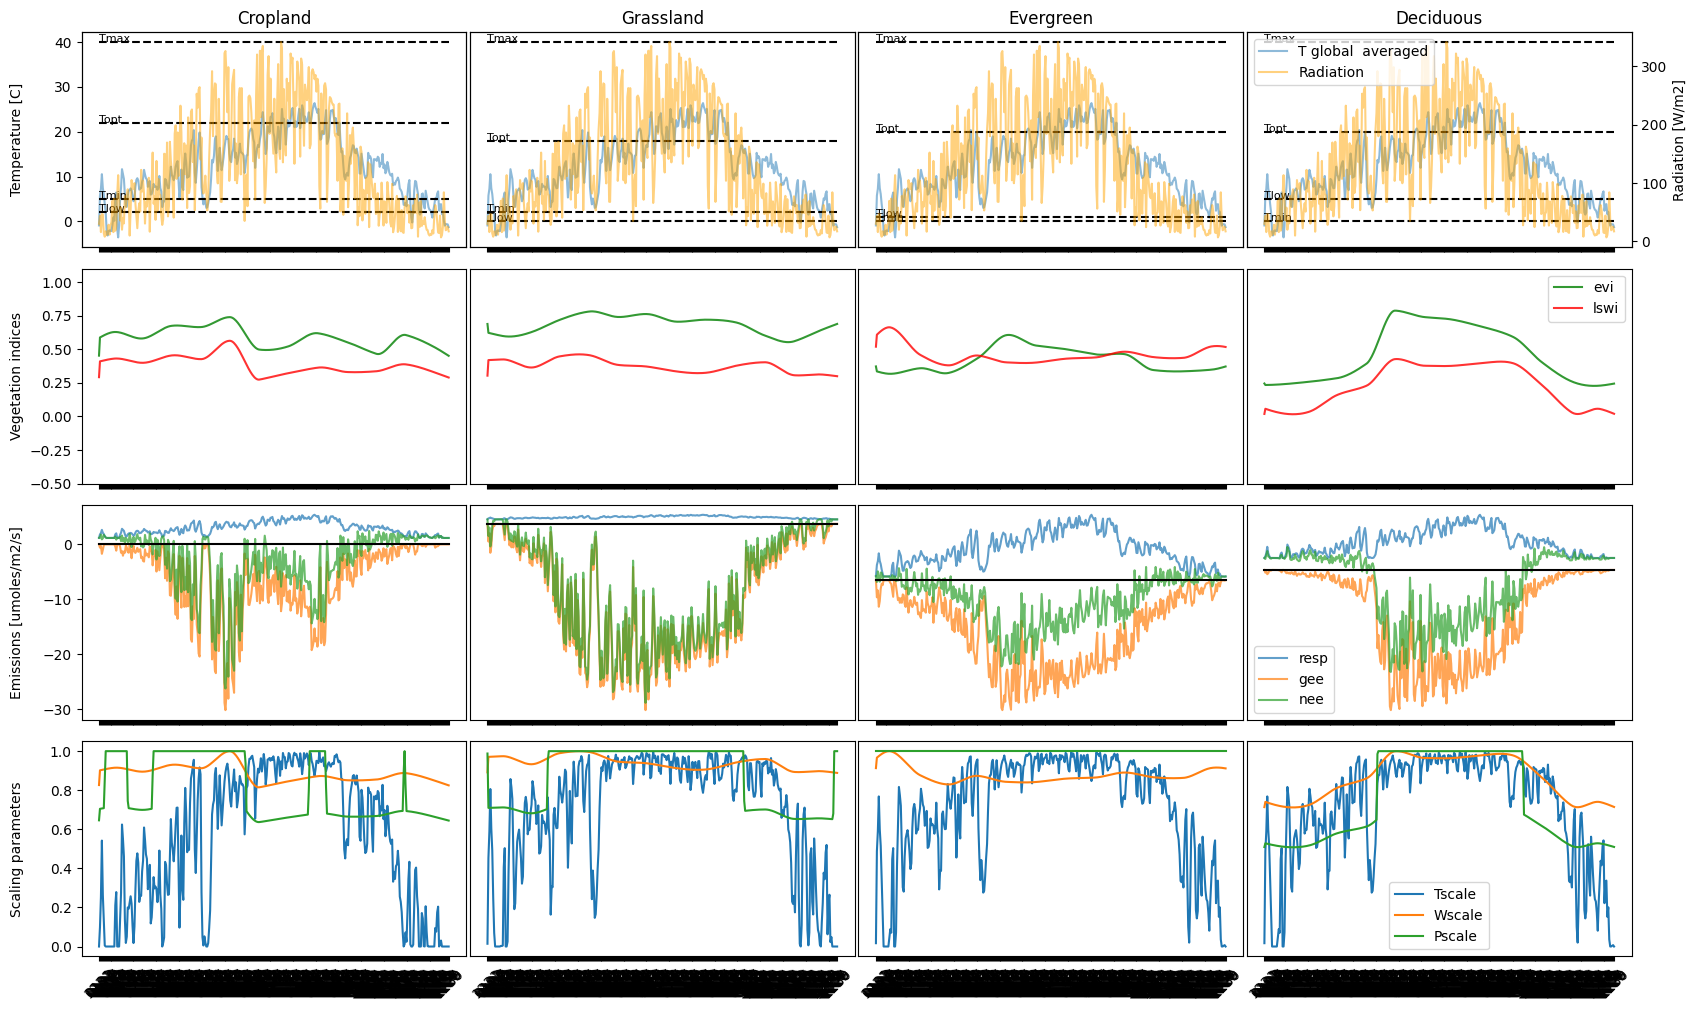

In [13]:
plot_vprm_params_per_veg_type(df_emissions, df_indices, group_by='%m%d')